# CRAFT + VietOCR/PARSeq

😍 Thanks to [`clovaai`](https://github.com/clovaai/) for their wonderful work! Most of the code for text detection is based on [their work](https://github.com/clovaai/CRAFT-pytorch/blob/e332dd8b718e291f51b66ff8f9ef2c98ee4474c8/test.py) (under MIT license).

## Setting up

In [9]:
import gc
import os

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

from clovaai_craft.craft import CRAFT
from clovaai_craft import craft_utils
from clovaai_craft import imgproc
from clovaai_craft.refine_net import RefineNet
from vietocr_api import load_vietocr_detector
from parseq import ParseqApp

plt.style.use('default')

def flush(*, verbose=True):
    if verbose:
        print('GC flushed %d objects' % gc.collect())
    else:
        gc.collect()

flush()

GC flushed 3798 objects


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

device, torch.cuda.get_device_properties(device)

('cuda:0',
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=16))

Before running the next cells, download the these files:

| Download URL | Save to path |
| ------------ | ------------ |
| [Google Drive](https://drive.google.com/file/d/1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ/view) | weights/craft_mlt_25k.pth |
| [Google Drive](https://drive.google.com/file/d/1XSaFwBkOaFOdtk4Ane3DFyJGPRw6v5bO/view) | weights/craft_refiner_CTW1500.pth |

If that was done correctly, the following cell would not fail.

In [3]:
trained_model = 'weights/craft_mlt_25k.pth'
assert os.path.exists(trained_model)

refiner_model = 'weights/craft_refiner_CTW1500.pth'
assert os.path.exists(refiner_model)

text_threshold = 0.7
low_text = 0.4
link_threshold = 0.4
canvas_size = 1280
mag_ratio = 1.5
poly = False

In [4]:
output_dir = 'out'
os.makedirs(output_dir, exist_ok=True)

Initialize model with pretrained weights.

In [5]:
flush()

net = CRAFT()
net = net.to(device)
# net = nn.DataParallel(net)
cudnn.benchmark = False

t = torch.load(trained_model, map_location=device, weights_only=True)
t = { key.replace('module.', ''): value for key, value in t.items() }
net.load_state_dict(t)
net.eval()

GC flushed 72 objects


/home/tekton/miniconda3/envs/invoiceie/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tekton/miniconda3/envs/invoiceie/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

Initialize LinkRefiner...

In [10]:
flush()

refine_net = RefineNet()
t = torch.load(refiner_model, map_location=device, weights_only=True)
t = { key.replace('module.', ''): value for key, value in t.items() }
refine_net.load_state_dict(t)
refine_net = refine_net.to(device)
refine_net.eval()

GC flushed 0 objects


RefineNet(
  (last_conv): Sequential(
    (0): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (aspp1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## CRAFT Inference time 🤔

In [11]:
def show_image(image: str | np.ndarray, *, title=None):
    if isinstance(image, str):
        image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    assert isinstance(image, np.ndarray)
    if image.ndim == 2:
        plt.imshow(image, cmap='gray')
    else:
        assert image.ndim == 3, 'Image must be RGB'
        plt.imshow(image)
    plt.imshow(image)
    if title is None:
        title = str(image.shape)
    plt.title(title)
    plt.show()

GC flushed 7 objects


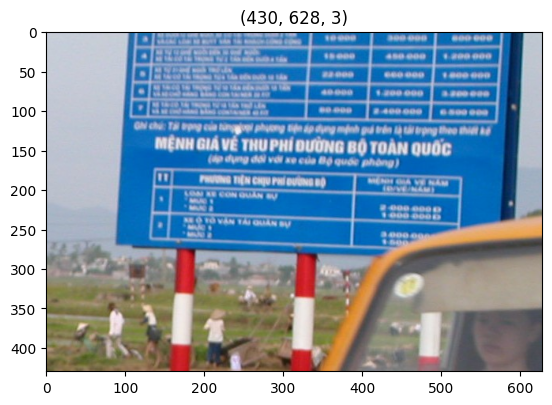

In [12]:
image_path = 'assets/sample-003.jpg'
flush()
show_image(image_path)

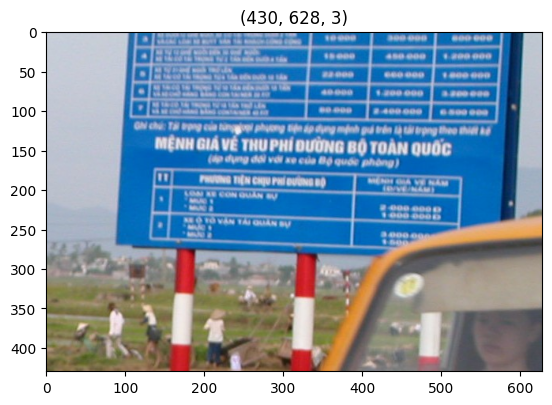

In [18]:
image = imgproc.loadImage(image_path)

show_image(image)

Resize the image...

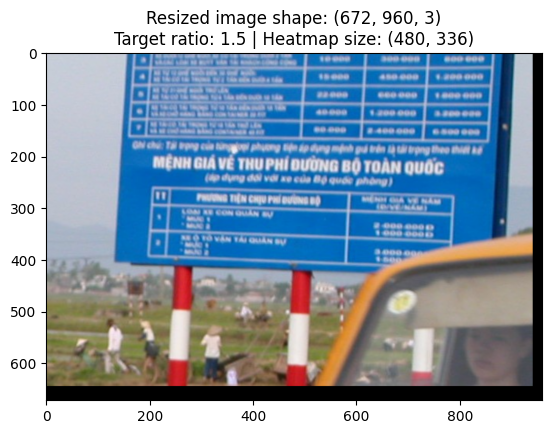

In [19]:
img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(
    image, 
    canvas_size, 
    interpolation=cv2.INTER_LINEAR,
    mag_ratio=mag_ratio
)

show_image(np.int16(img_resized), 
           title='Resized image shape: ({}, {}, {})\n'
           'Target ratio: {} | Heatmap size: {}'.format(
               *(img_resized.shape), target_ratio, size_heatmap
           ))

In [20]:
ratio_w = 1 / target_ratio
ratio_h = ratio_w

ratio_w, ratio_h

(0.6666666666666666, 0.6666666666666666)

Pre-process the image...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


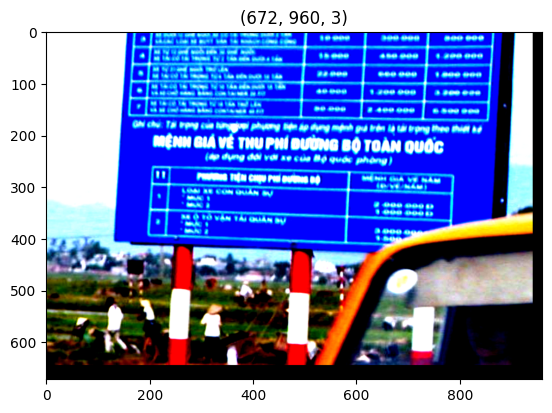

In [21]:
x = imgproc.normalizeMeanVariance(img_resized)

show_image(x)

Forward pass...

In [22]:
x = torch.from_numpy(x).permute(2, 0, 1)
x = Variable(x.unsqueeze(0), requires_grad=False).to(device)

with torch.no_grad():
    y, feature = net(x)

y.shape, feature.shape

(torch.Size([1, 336, 480, 2]), torch.Size([1, 32, 336, 480]))

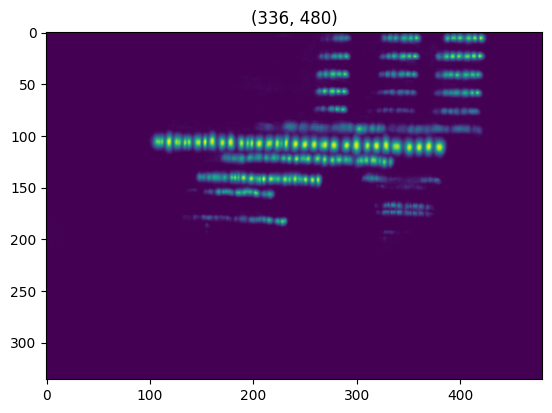

In [23]:
score_text = y[0, :, :, 0].cpu().data.numpy()

show_image(score_text)

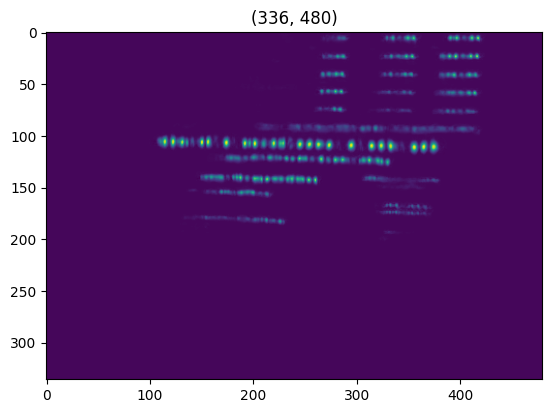

In [24]:
score_link = y[0, :, :, 1].cpu().data.numpy()

show_image(score_link)

Refine link...

In [25]:
with torch.no_grad():
    y_refiner = refine_net(y, feature)

y_refiner.shape, y.shape, feature.shape

(torch.Size([1, 336, 480, 1]),
 torch.Size([1, 336, 480, 2]),
 torch.Size([1, 32, 336, 480]))

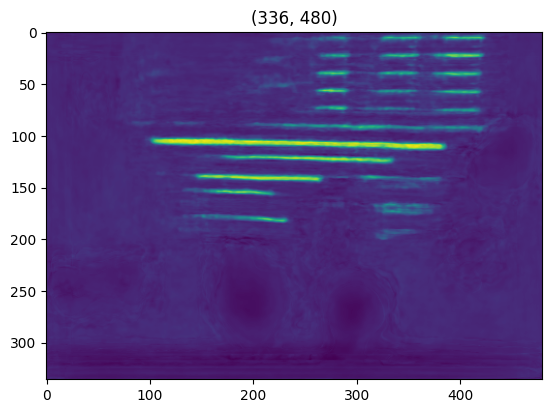

In [26]:
score_link = y_refiner[0, :, :, 0].cpu().data.numpy()

show_image(score_link)

Post-process...

In [27]:
boxes, polys = craft_utils.getDetBoxes(score_text, score_link,
                                       text_threshold, link_threshold,
                                       low_text, poly)
boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
for k in range(len(polys)):
    if polys[k] is None:
        polys[k] = boxes[k]
    
print('Boxes: ({} in total)'.format(len(boxes)))
for t in boxes:
    print(t)
print()
print('Polys: ({} in total)'.format(len(polys)))
for t in polys:
    print(t)

Boxes: (15 in total)
[[440.         4.      ]
 [482.66666    4.      ]
 [482.66666   13.333333]
 [440.        13.333333]]
[[512.          2.6666667]
 [566.6667      2.6666667]
 [566.6667     14.666667 ]
 [512.         14.666667 ]]
[[502.66666   25.333334]
 [565.3333    25.333334]
 [565.3333    37.333332]
 [502.66666   37.333332]]
[[438.66666   28.      ]
 [481.33334   28.      ]
 [481.33334   37.333332]
 [438.66666   37.333332]]
[[349.33334   49.333332]
 [390.66666   49.333332]
 [390.66666   60.      ]
 [349.33334   60.      ]]
[[510.66666   52.      ]
 [562.6667    52.      ]
 [562.6667    61.333332]
 [510.66666   61.333332]]
[[349.33334   73.333336]
 [389.33334   73.333336]
 [389.33334   82.666664]
 [349.33334   82.666664]]
[[513.3333  76.    ]
 [561.3333  76.    ]
 [561.3333  84.    ]
 [513.3333  84.    ]]
[[364.  96.]
 [388.  96.]
 [388. 104.]
 [364. 104.]]
[[389.33334  121.333336]
 [432.       121.333336]
 [432.       132.      ]
 [389.33334  132.      ]]
[[137.44942 129.26637]
 [

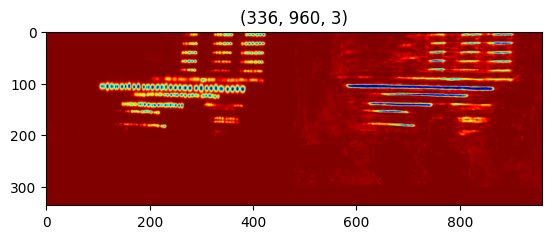

In [28]:
render_img = score_text.copy()
render_img = np.hstack((render_img, score_link))
ret_score_text = imgproc.cvt2HeatmapImg(render_img)

show_image(ret_score_text)

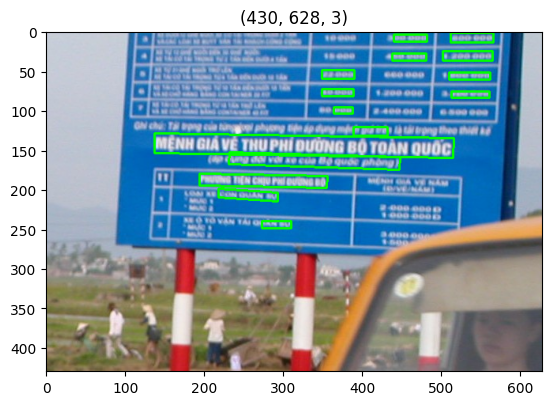

In [29]:
t = np.int32(image.copy())

# rng = np.random.RandomState(2024)
# colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]
color = (0, 255, 0)
for box in boxes:
    points = [np.int32(point) for point in box]
    points.append(points[0])
    # color = colors[rng.randint(0, len(colors))]
    for i in range(1, len(points)):
        cv2.line(t, points[i-1], points[i], color, 2)

show_image(t)

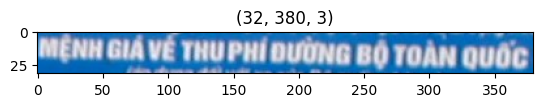

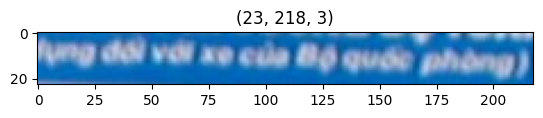

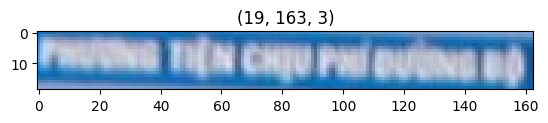

In [30]:
def crop_boxes(image: np.ndarray, boxes):
    crops = []
    for box in boxes:
        box = np.int32(box)
        x_values = box[:, 0]
        y_values = box[:, 1]
        x1, x2 = min(x_values), max(x_values)
        y1, y2 = min(y_values), max(y_values)
        assert x1 + 1 < x2, '{}, {}'.format(x1, x2)
        assert y1 + 1 < y2, '{}, {}'.format(y1, y2)
        
        # I still don't understand why x and y are flipped 🤔
        crops.append(image[y1:y2 + 1, x1:x2 + 1].copy())
    return crops

small_images = crop_boxes(np.int32(image.copy()), boxes)

for i, small_image in enumerate(small_images[-5:-2]):
    show_image(small_image)

## VietOCR Inference

In [31]:
vietocr_detector = load_vietocr_detector(device=device)

/home/tekton/miniconda3/envs/invoiceie/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!


/home/tekton/miniconda3/envs/invoiceie/lib/python3.10/site-packages/vietocr/tool/predictor.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

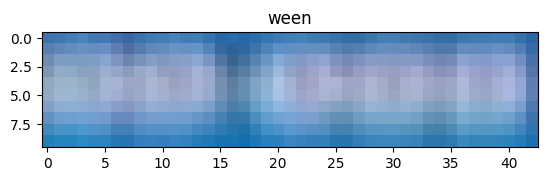

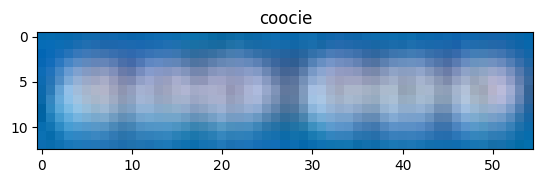

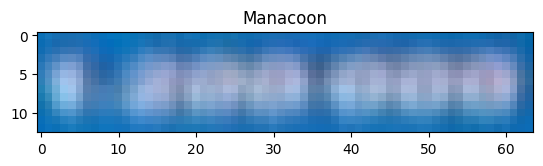

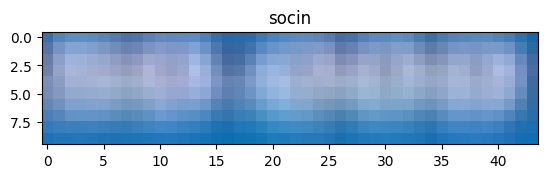

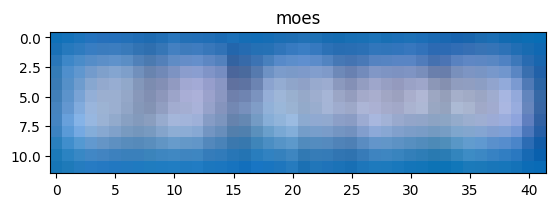

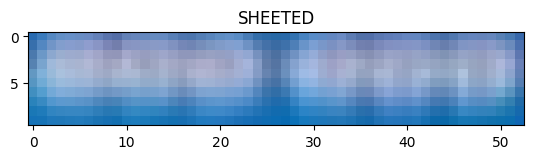

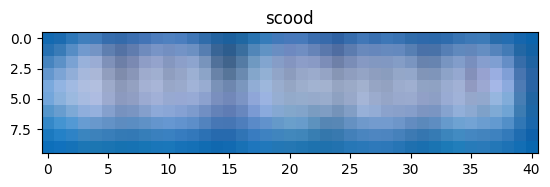

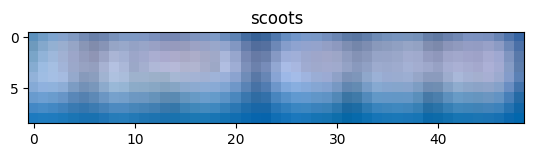

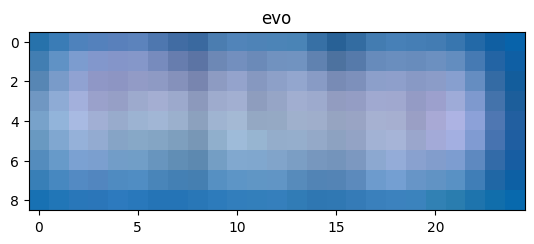

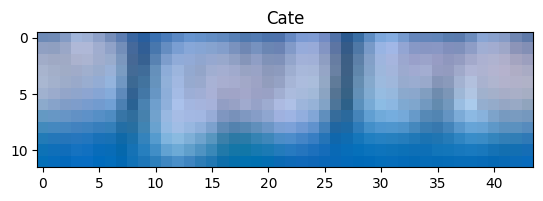

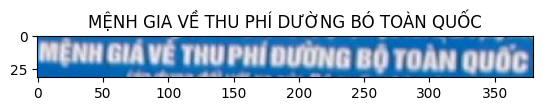

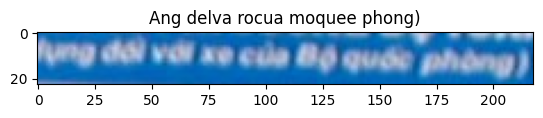

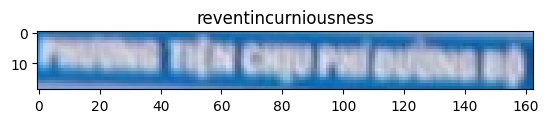

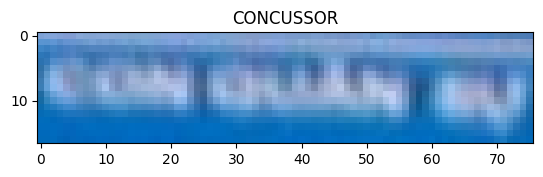

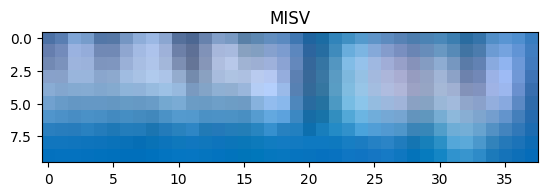

In [32]:
small_image_objs = list(map(
    lambda arr: Image.fromarray(np.uint8(arr), 'RGB'),
    small_images
))

small_texts = vietocr_detector.predict_batch(small_image_objs)

for i in range(len(small_texts)):
    show_image(small_images[i], title=small_texts[i])

## PARSeq inference

In [33]:
parseq_model = ParseqApp(device=device)

In [34]:
texts = []
for small_image in small_images:
    obj = Image.fromarray(small_image, 'RGB')
    texts.append(parseq_model('parseq', obj, verbose=False)[0])

texts

Downloading: "https://github.com/baudm/parseq/zipball/main" to /home/tekton/.cache/torch/hub/main.zip
/home/tekton/miniconda3/envs/invoiceie/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://github.com/baudm/parseq/releases/download/v1.0.0/parseq-bb5792a6.pt" to /home/tekton/.cache/torch/hub/checkpoints/parseq-bb5792a6.pt
100%|██████████| 91.0M/91.0M [03:24<00:00, 467kB/s] 


['-',
 '###',
 '11111111111111111111111111',
 '11111111111',
 'States',
 '-',
 '-',
 '-',
 'm',
 '11111111111',
 'HANDEGE',
 'THE',
 'IIII',
 '11111111111111111111111111',
 'prevated']

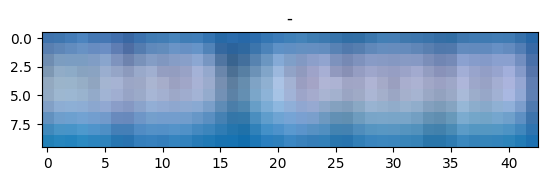

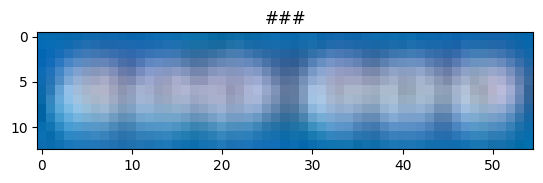

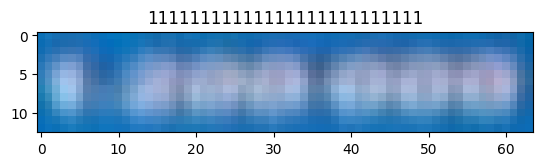

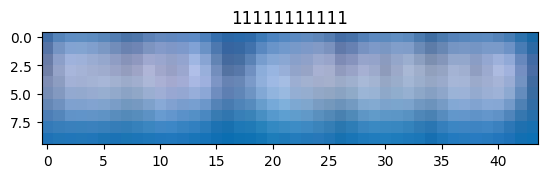

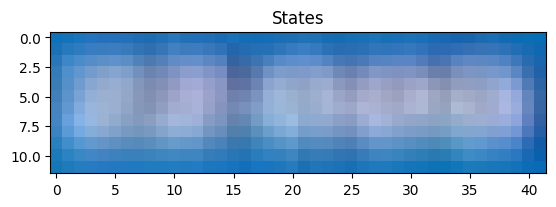

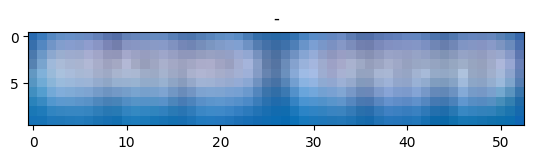

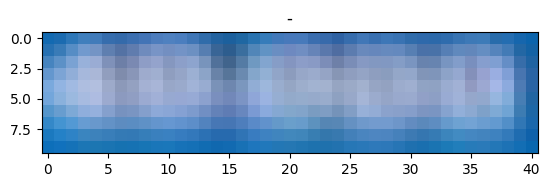

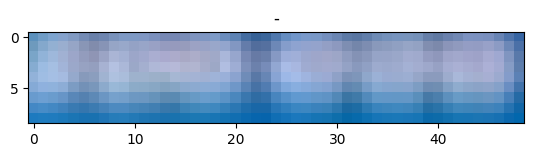

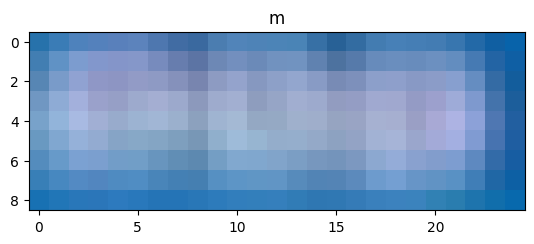

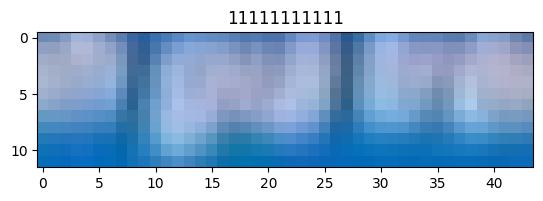

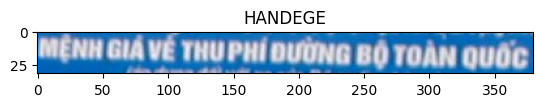

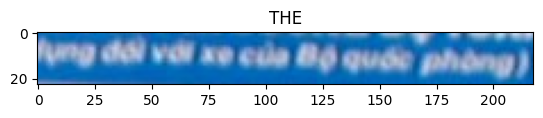

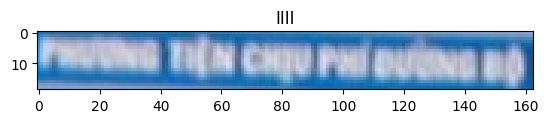

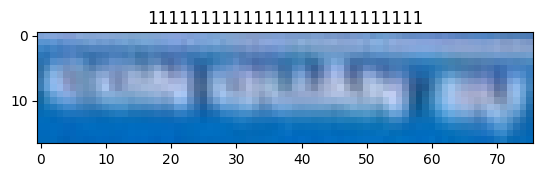

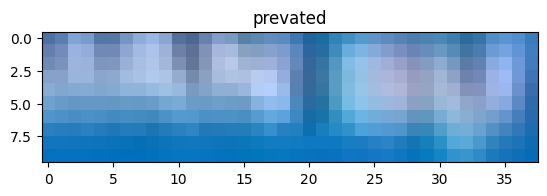

In [36]:
for text, small_image in zip(texts, small_images):
    show_image(small_image, title=text)